# Описание проекта

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.<br>
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. <br>
У вас будет несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. <br>
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.
Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.<br>

# Подготовительная часть

### Установка библиотек

Моделирование

In [1]:
!pip install phik  -q # -q убирает необязательные выводы в командах Linux
!pip install scikit-learn==1.4.0

Визуализация

In [2]:
!pip install matplotlib==3.8.4
!pip install seaborn==0.13.2

### Импорт библиотек

<i>Работа с данными, визуализация<i>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Настройка pandas

In [4]:
pd.option_context("display.max_rows", None, "display.max_columns", None);

<i>Матрица корреляции<i>

In [5]:
from phik.report import plot_correlation_matrix
from phik import phik_matrix

<i>Библиотека sklearn<i>

In [6]:
from sklearn.model_selection import train_test_split

# загружаем класс pipeline
from sklearn.pipeline import Pipeline, make_pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   RobustScaler)

from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import (roc_auc_score,
                             f1_score,
                             make_scorer)

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# загружаем нужные модели
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVC



# загружаем функцию для проверки значимости показателей в модели
from sklearn.inspection import permutation_importance


from sklearn.tree import plot_tree

## Задача 1

Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

### Загрузка данных

In [7]:
# Тренировочная выборка
df_train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
# Входные признаки тестовой выборки
X_test = pd.read_csv('/datasets/test_features.csv')
# Целевой признак тестовой выборки
y_test = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

### Предобработка данных

Исследует датафреймы на соответствие данных

#### df_train

In [8]:
display(df_train.head())
df_train.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


В столбцах 'dept' и 'level' присутствуют пропуски.

In [9]:
df_train[df_train['dept'].isna()==True]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [10]:
df_train[df_train['level'].isna()==True]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71


Пропуски можно заполнить данными с аналогичными характеристиками, но по заданию их следует заменить с использованием пайплайна

#### X_test

In [11]:
display(X_test.head())
X_test.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [12]:
X_test[X_test['dept'].isna()==True]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
1196,832342,NaN,junior,medium,1,no,no,4,28800


In [13]:
X_test[X_test['level'].isna()==True]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
312,471990,sales,NaN,low,1,no,no,3,12000


Пропуски можно заполнить данными с аналогичными характеристиками, но по заданию их следует заменить с использованием пайплайна

#### y_test

In [14]:
display(y_test.head())
y_test.info()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


#### Вывод
1) Данные соответствуют заявленным;<br>
2) Найдены пропуски, замена будет произведена в пайплайне

### Исследовательский анализ данных

Исследуем датафреймы на наличие дубликатов и выделяющихся значений

In [15]:
def check_unique(data):
    data_ = data.select_dtypes(include=[np.object])
    for i in data_:
        print(f"столбец: {i}")
        display(data[i].unique())

#### df_train

Проверка строковых значений

In [16]:
check_unique(df_train)

столбец: dept


/tmp/ipykernel_308/558477774.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_ = data.select_dtypes(include=[np.object])


array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

столбец: level


array(['junior', 'middle', 'sinior', nan], dtype=object)

столбец: workload


array(['medium', 'high', 'low'], dtype=object)

столбец: last_year_promo


array(['no', 'yes'], dtype=object)

столбец: last_year_violations


array(['no', 'yes'], dtype=object)

In [17]:
def check_pie(data, column_agg, index_plt, agg_value='salary', size=[1, 1], num_plt=1):
    pivot_ = data.pivot_table(index = column_agg,
                              values =agg_value,
                              aggfunc=['count']).reset_index(drop=False)
    pivot_.columns = [column_agg, 'count']
    pivot_ = pivot_.sort_values(by='count', ascending=False)
    plt.figure(figsize=(4, 4))
    plt.subplot(*size, num_plt)
    plt.pie(pivot_['count'],
            labels=pivot_[column_agg],
            autopct='%1.1f%%')
    plt.title(f"Соотношение по {column_agg}")
    display(pivot_)

,dept,count
3,sales,1512
4,technology,866
2,purchasing,610
1,marketing,550
0,hr,456


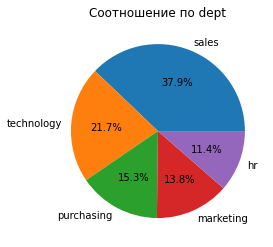

In [18]:
check_pie(df_train, 'dept', 1)

,level,count
0,junior,1894
1,middle,1744
2,sinior,358


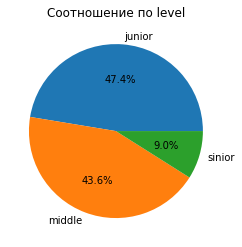

In [19]:
check_pie(df_train, 'level', 1)

,workload,count
2,medium,2066
1,low,1200
0,high,734


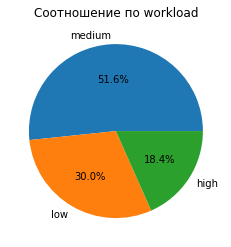

In [20]:
check_pie(df_train, 'workload', 1)

,last_year_promo,count
0,no,3880
1,yes,120


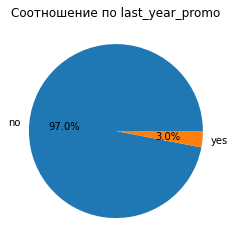

In [21]:
check_pie(df_train, 'last_year_promo', 1)

,last_year_violations,count
0,no,3441
1,yes,559


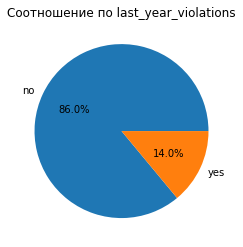

In [22]:
check_pie(df_train, 'last_year_violations', 1)

1) Больше всего данных по отделу продаж;<br>
2) Мидлов и джунов в компании примерно одинаково;<br>
3) Соотношение по нагруженности выглядить адекватным;<br>
4) Каждый 7ой нарушает

Данные имеют корректный вид

Проверка численных значений

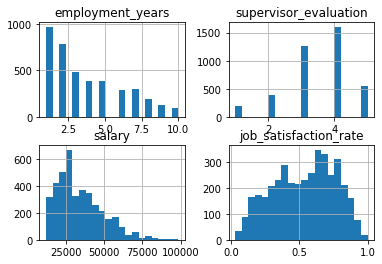

In [23]:
df_train.drop(columns='id', axis=0).hist(bins=20);

Распределения похожи на смещенное нормальное

In [24]:
print(df_train['employment_years'].sort_values().unique())

[ 1  2  3  4  5  6  7  8  9 10]


Сразу добавим список численных значений, но рейтинг имеет две вершины (разделение приблизительно на 0.5)

In [25]:
num_columns = list(df_train.select_dtypes(include='number').drop(columns=['id'], axis=0).columns)
num_columns

['employment_years',
 'supervisor_evaluation',
 'salary',
 'job_satisfaction_rate']

In [26]:
df_train.select_dtypes(include=[np.object]).columns

/tmp/ipykernel_308/927558949.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_train.select_dtypes(include=[np.object]).columns


Index(['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations'], dtype='object')

#### X_test

Проверка строковых значений

In [27]:
check_unique(X_test)

столбец: dept


/tmp/ipykernel_308/558477774.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_ = data.select_dtypes(include=[np.object])


array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

столбец: level


array(['junior', 'middle', 'sinior', nan], dtype=object)

столбец: workload


array(['medium', 'low', 'high', ' '], dtype=object)

столбец: last_year_promo


array(['no', 'yes'], dtype=object)

столбец: last_year_violations


array(['no', 'yes'], dtype=object)

В столбцах 'workload', 'dept' замечены значения ' ', которые стоит заменить на None 

In [28]:
def replace_space(x):
    if x == ' ':
        return np.nan
    else:
        return x

In [29]:
X_test['dept'] = X_test['dept'].apply(replace_space)
X_test['workload'] = X_test['workload'].apply(replace_space)

,dept,count
3,sales,763
4,technology,455
1,marketing,279
2,purchasing,273
0,hr,227


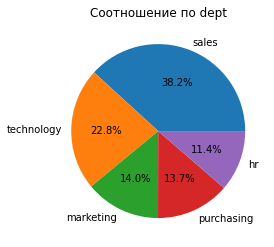

In [30]:
check_pie(X_test, 'dept', 1)

,level,count
0,junior,974
1,middle,854
2,sinior,171


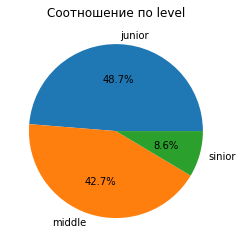

In [31]:
check_pie(X_test, 'level', 1)

,workload,count
2,medium,1043
1,low,593
0,high,363


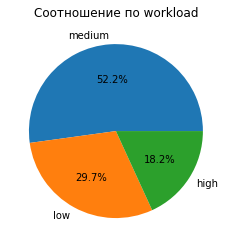

In [32]:
check_pie(X_test, 'workload', 1)

,last_year_promo,count
0,no,1937
1,yes,63


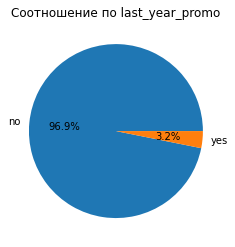

In [33]:
check_pie(X_test, 'last_year_promo', 1)

,last_year_violations,count
0,no,1738
1,yes,262


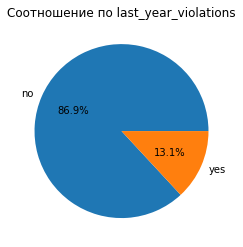

In [34]:
check_pie(X_test, 'last_year_violations', 1)

Распределение категориальных признаков аналогично df_train

<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Выше добавил распределение категориальных признаков</div>

Проверка численных значений

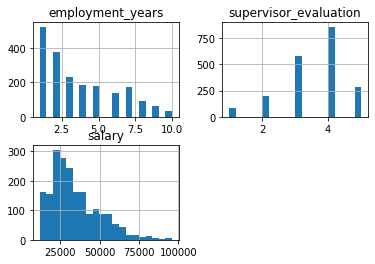

In [35]:
X_test.drop(columns='id', axis=0).hist(bins=20);

Распределения похожи на смещенное нормальное

#### y_test

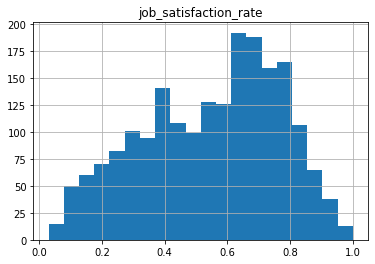

In [36]:
y_test.drop(columns='id', axis=0).hist(bins=20);

Здесь также ориентировочно 2 вершины распределения

#### Проверка соответствия уникальных значений в тренирвочной и тестовой выборках

Далее проверим соответствие значений датафреймов. Проверять будем признаки со строковыми типами данных

In [37]:
check_table = pd.concat([df_train.drop(columns='id', axis=0), X_test]).select_dtypes(include=[np.object])
check_unique(check_table)

столбец: dept


/tmp/ipykernel_308/1361677258.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  check_table = pd.concat([df_train.drop(columns='id', axis=0), X_test]).select_dtypes(include=[np.object])
/tmp/ipykernel_308/558477774.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_ = data.select_dtypes(include=[np.object])


array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

столбец: level


array(['junior', 'middle', 'sinior', nan], dtype=object)

столбец: workload


array(['medium', 'high', 'low', nan], dtype=object)

столбец: last_year_promo


array(['no', 'yes'], dtype=object)

столбец: last_year_violations


array(['no', 'yes'], dtype=object)

Неявных дубликатов не обнаружено

#### Корреляционный анализ

Проведем корреляционный анализ

In [38]:
# создаём список с наименованиями непрерывных признаков
interval_cols = list(df_train.select_dtypes(include='number').columns)[1:]

# считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(df_train.drop(columns='id'), interval_cols=interval_cols) 

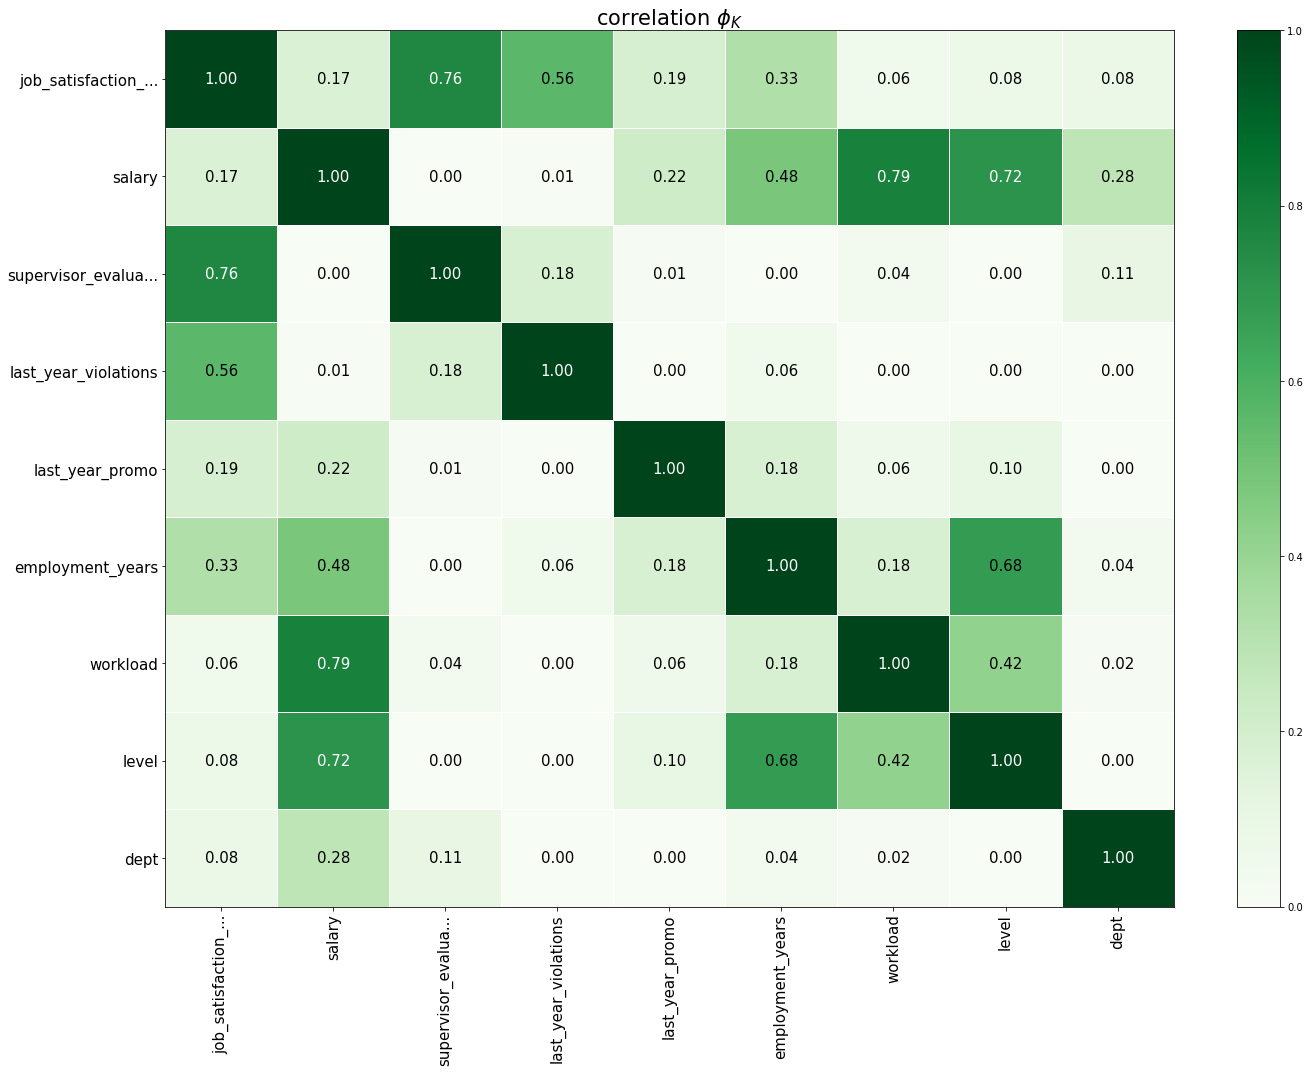

In [39]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

1) По матрице отдел имеет самую низкую корреляцию со всеми признаками кроме зарплат;<br>
2) Также относительно низкую корреляцию с другими признаками имеет наличие акций за последний год;<br>
3) Возможно, далее модель будет обучаться без этого признака

#### Вывод

1) Найдем пробелы (' ') в выборках и замены на проупски;<br>
2) Распределения похожи на нормальные, но целевой признак имеет 2 вершины;<br>
3) Отдел и наличие акций за последний год имеют самую низкую корреляцию с другими признаками

<b>Добавление к предыдущему варианту вывода<b>

1) Больше всего данных по отделу продаж;<br>
2) Мидлов и джунов в компании примерно одинаково, сеньоров в ~10 раз меньше, чем остальных групп;<br>
3) Соотношение по нагруженности выглядить адекватным, больше всего средней нагруженности;<br>
4) Каждый 7ой нарушает

### Подготовка данных

#### Подготовка переменных и констант

Константы для моделей

In [40]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

Выделим целевой признак и уберем его из переменных с использумыми столбцами. В нашем случае числовыми.

Название столбца с целевым признаком

In [41]:
target_column = 'job_satisfaction_rate'

Название колоно для кодирования

In [42]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']

In [43]:
num_columns = [x for x in num_columns if x != target_column]
num_columns

['employment_years', 'supervisor_evaluation', 'salary']

Подготовка тренировочных и тестовых данных

In [44]:
df_train = df_train.sort_values(by=['id'])
X_train_use = df_train.drop(columns=['id', target_column])
y_train_use = df_train[target_column]

X_test = X_test.sort_values(by='id')
y_test = y_test.sort_values(by='id')
X_test_use = X_test.drop(columns='id', axis=0)
y_test_use = y_test[target_column]

#### Пайпланы для предобработки

Добавление пайплайнов предобработки датасетов

In [45]:
display(f"ohe_columns: {ohe_columns}")
display(f"ord_columns: {ord_columns}")

"ohe_columns: ['dept', 'last_year_promo', 'last_year_violations']"

"ord_columns: ['level', 'workload']"

In [46]:
check_unique(X_train_use[ord_columns])

столбец: level


/tmp/ipykernel_308/558477774.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_ = data.select_dtypes(include=[np.object])


array(['junior', 'middle', 'sinior', nan], dtype=object)

столбец: workload


array(['low', 'medium', 'high'], dtype=object)

In [47]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(
                                missing_values=np.nan,
                                strategy='most_frequent'
                           )),
     ('ohe', OneHotEncoder(
                 drop='first',
                 handle_unknown='ignore',
                 sparse_output=False))
    ]
    )

In [48]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(
                                      missing_values=np.nan,
                                      strategy='most_frequent'
                                  )),
     ('ord', OrdinalEncoder(
                 categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high']
                 ], 
                 handle_unknown='use_encoded_value',
                 unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan,
                                               strategy='most_frequent'))
    ]
)

In [49]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

### Обучение моделей

#### Добавление метрики SMAPE

Для начала создадим метрику для сравнения моделей SMAPE

In [50]:
def calculate_smape(actual, predicted):
    abs_dif = np.abs(actual - predicted)
    half_sum_abs = 0.5 * (np.abs(actual) + np.abs(predicted))
    smape = 100 * np.mean(abs_dif / half_sum_abs)
    return smape

In [51]:
smape = make_scorer(
    calculate_smape,
    greater_is_better=False
)

#### Пайплайн для моделей обучения

Добавление пайплайна для моделирования

In [52]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [53]:
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(10, 25),
        'models__max_features': range(10, 100),
        'models__min_samples_split': range(2, 50),
        'models__min_samples_leaf': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

#### Поиск лучшей модели

In [54]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape,
    n_jobs=-1
)
randomized_search.fit(X_train_use, y_train_use)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pip...
                                         'models__max_features': range(10, 100),
                                         'models__min_samples_leaf': range(2, 10),
                                         'models__min_samples_split': range(2, 50),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   scoring=make_scorer(calculate_smape, greater_is_better=False, response_method='predict'))

Отберем лучшую модель

In [55]:
best_regression = randomized_search.best_estimator_

Выведем на экран параметры лучшей модели

In [56]:
print('Лучшая модель и её параметры:\n\n', best_regression)
print('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
# y_test_pred = randomized_search.predict(X_test_use)
y_test_pred = best_regression.predict(X_test_use)
print(f'Метрика SMAPE на тестовой выборке: {calculate_smape(np.array(y_test_use), y_test_pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

Модуль SMAPE на тестовой и тренировочной выборках получился меньше 15, поэтому модель можно считать удовлетворительной

Визуализация дерева решений. Выведем первые 2 уровня для просмотра наиболее значимых переменных

In [57]:
pipe_final.named_steps['preprocessor'].fit_transform(X_train_use)
;

''

In [58]:
features_names_X = list(pipe_final.named_steps['preprocessor'].get_feature_names_out())
features_names_X = [[x[5:], features_names_X.index(x) + 1] for x in features_names_X]
features_names_X

[['dept_marketing', 1],
 ['dept_purchasing', 2],
 ['dept_sales', 3],
 ['dept_technology', 4],
 ['last_year_promo_yes', 5],
 ['last_year_violations_yes', 6],
 ['level', 7],
 ['workload', 8],
 ['employment_years', 9],
 ['supervisor_evaluation', 10],
 ['salary', 11]]

Text(0.5, 0.875, 'x[9] <= 0.023\nsquared_error = 0.051\nsamples = 4000\nvalue = 0.534')

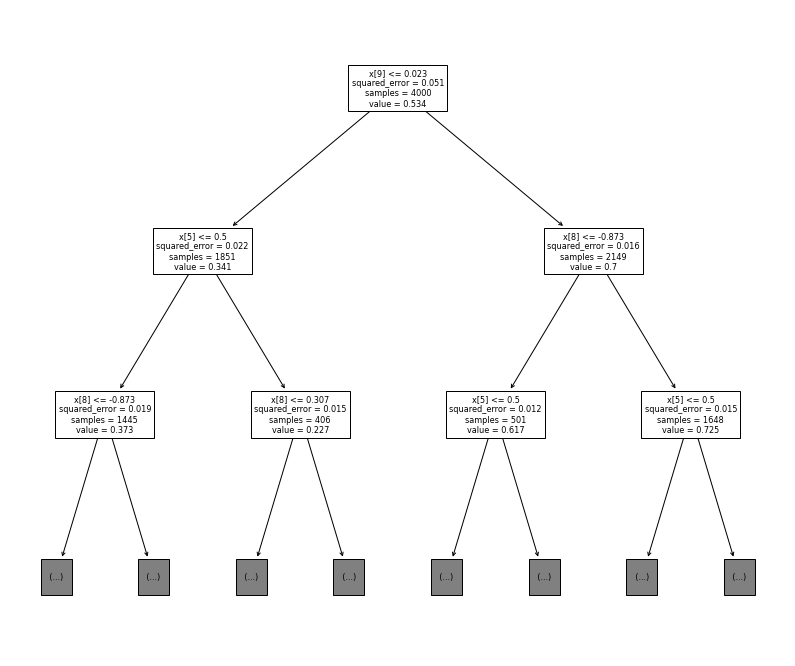

In [59]:
plt.figure(figsize=(14, 12))

plot_tree(best_regression.named_steps['models'],
          max_depth=2)[0]

По дереву решений сначала смотрится стаж, после акции компании или нагруженность.

Ниже результаты других моделей

In [60]:
result = pd.DataFrame(randomized_search.cv_results_)
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')) 

,rank_test_score,param_models,mean_test_score,params
7,1,DecisionTreeRegressor(random_state=42),-14.604036,"{'preprocessor__num': StandardScaler(), 'model..."
5,2,DecisionTreeRegressor(random_state=42),-14.694876,"{'preprocessor__num': StandardScaler(), 'model..."
8,3,DecisionTreeRegressor(random_state=42),-14.894139,"{'preprocessor__num': MinMaxScaler(), 'models_..."
4,4,DecisionTreeRegressor(random_state=42),-15.170080,"{'preprocessor__num': MinMaxScaler(), 'models_..."
2,5,DecisionTreeRegressor(random_state=42),-15.209977,"{'preprocessor__num': MinMaxScaler(), 'models_..."
1,6,DecisionTreeRegressor(random_state=42),-15.224733,"{'preprocessor__num': 'passthrough', 'models__..."
3,7,DecisionTreeRegressor(random_state=42),-15.358330,"{'preprocessor__num': MinMaxScaler(), 'models_..."
6,8,DecisionTreeRegressor(random_state=42),-15.366928,"{'preprocessor__num': StandardScaler(), 'model..."
0,9,DecisionTreeRegressor(random_state=42),-15.480978,"{'preprocessor__num': MinMaxScaler(), 'models_..."
9,10,DecisionTreeRegressor(random_state=42),-15.557348,"{'preprocessor__num': StandardScaler(), 'model..."


Соединим предсказанные значения и id

In [61]:
y_test['pred_satisfaction_rate'] = y_test_pred

In [62]:
y_for_future = y_test

### Вывод

Была найдена лучшая модель регрегесии. Модель оценивалась с помощью метрики SMAPE.<br>
Ею оказалось дерево регрессии:<br>
1) SMAPE:<br>
тренировочная выборка: -14.90125323893982,<br>
тестовая выборка: 13.713203079356543;<br>
2) Параметры:<br>
- max_depth=22;<br>
- max_features=43;<br>
- min_samples_leaf=7;<br>
- min_samples_split=14.

Дерево регрессии оказалось лучшим, вероятно, из-за деления плоскости. В отличие от линейной регрессии мы получаем непрямолинейную зависимость.

## Задача 2

Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

### Загрузка данных

Несмотря на то, что датасет одинаковы за исключением нового признака quit повторим все шаги из задачи 1

In [63]:
df_train_second = pd.read_csv('/datasets/train_quit.csv')
X_test_second = pd.read_csv('/datasets/test_features.csv')
y_test_second = pd.read_csv('/datasets/test_target_quit.csv')

### Предобработка данных

#### df_train

In [64]:
display(df_train_second.head())
df_train_second.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


#### X_test_second

In [65]:
display(X_test_second.head())
X_test_second.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [66]:
X_test_second[X_test_second['dept'].isna()==True]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
1196,832342,NaN,junior,medium,1,no,no,4,28800


In [67]:
X_test_second[X_test_second['level'].isna()==True]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
312,471990,sales,NaN,low,1,no,no,3,12000


#### y_test_second

In [68]:
display(y_test_second.head())
y_test_second.info()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


#### Вывод
1) Данные соответствуют заявленным;<br>
2) Найдены пропуски, замена будет произведена в пайплайне

### Исследовательский анализ данных

#### Исследовательский анализ

##### df_train

In [69]:
check_unique(df_train_second)

столбец: dept


/tmp/ipykernel_308/558477774.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_ = data.select_dtypes(include=[np.object])


array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
      dtype=object)

столбец: level


array(['middle', 'junior', 'sinior'], dtype=object)

столбец: workload


array(['high', 'medium', 'low'], dtype=object)

столбец: last_year_promo


array(['no', 'yes'], dtype=object)

столбец: last_year_violations


array(['no', 'yes'], dtype=object)

столбец: quit


array(['no', 'yes'], dtype=object)

,dept,count
3,sales,1438
4,technology,928
2,purchasing,588
1,marketing,582
0,hr,464


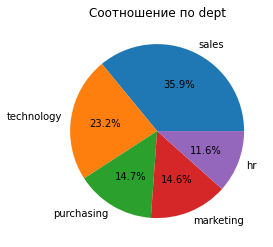

In [70]:
check_pie(df_train_second, 'dept', 1)

,level,count
0,junior,1949
1,middle,1694
2,sinior,357


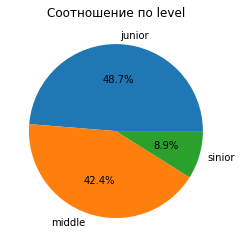

In [71]:
check_pie(df_train_second, 'level', 1)

,workload,count
2,medium,2118
1,low,1208
0,high,674


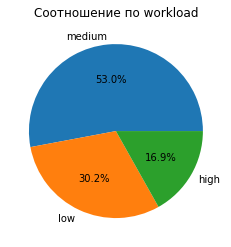

In [72]:
check_pie(df_train_second, 'workload', 1)

,last_year_promo,count
0,no,3887
1,yes,113


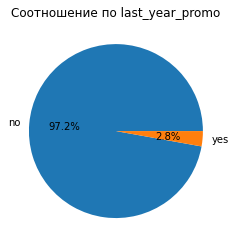

In [73]:
check_pie(df_train_second, 'last_year_promo', 1)

,last_year_violations,count
0,no,3455
1,yes,545


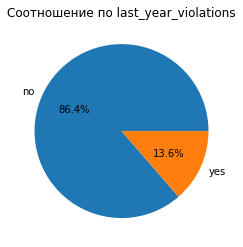

In [74]:
check_pie(df_train_second, 'last_year_violations', 1)

,quit,count
0,no,2872
1,yes,1128


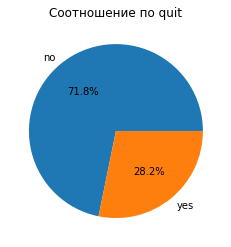

In [75]:
check_pie(df_train_second, 'quit', 1)

1) Наибольшее количество сотрудников из отдела продаж;<br>
2) джунов больше всего;<br>
3) наружает каждый 7ой ;<br>

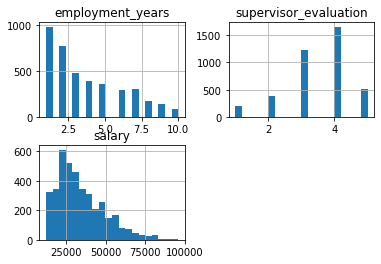

In [76]:
df_train_second.drop(columns='id', axis=0).hist(bins=20);

##### X_test_second

In [77]:
check_unique(X_test_second)

столбец: dept


/tmp/ipykernel_308/558477774.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_ = data.select_dtypes(include=[np.object])


array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

столбец: level


array(['junior', 'middle', 'sinior', nan], dtype=object)

столбец: workload


array(['medium', 'low', 'high', ' '], dtype=object)

столбец: last_year_promo


array(['no', 'yes'], dtype=object)

столбец: last_year_violations


array(['no', 'yes'], dtype=object)

В столбцах 'workload', 'dept' замечены значения ' ', которые стоит заменить на None 

In [78]:
X_test_second['dept'] = X_test_second['dept'].apply(replace_space)
X_test_second['workload'] = X_test_second['workload'].apply(replace_space)

,dept,count
3,sales,763
4,technology,455
1,marketing,279
2,purchasing,273
0,hr,227


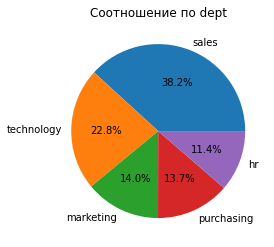

In [79]:
check_pie(X_test_second, 'dept', 1)

,level,count
0,junior,974
1,middle,854
2,sinior,171


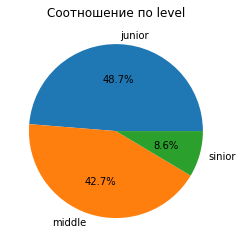

In [80]:
check_pie(X_test_second, 'level', 1)

,workload,count
2,medium,1043
1,low,593
0,high,363


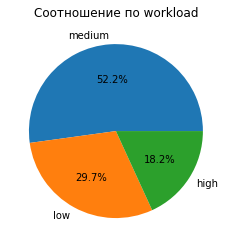

In [81]:
check_pie(X_test_second, 'workload', 1)

,last_year_promo,count
0,no,1937
1,yes,63


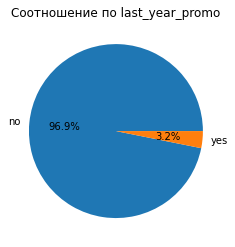

In [82]:
check_pie(X_test_second, 'last_year_promo', 1)

,last_year_violations,count
0,no,1738
1,yes,262


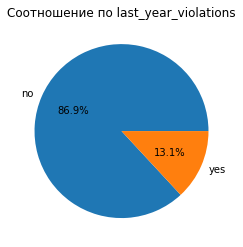

In [83]:
check_pie(X_test_second, 'last_year_violations', 1)

Вывод аналогичен предыдущему по df_train

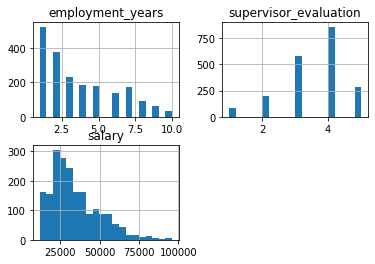

In [84]:
X_test_second.drop(columns='id', axis=0).hist(bins=20);

##### y_test_second

In [85]:
check_unique(y_test_second)

столбец: quit


/tmp/ipykernel_308/558477774.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_ = data.select_dtypes(include=[np.object])


array(['yes', 'no'], dtype=object)

,quit,count
0,no,1436
1,yes,564


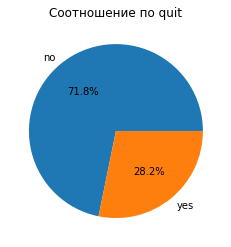

In [86]:
check_pie(y_test_second, 'quit', 1, agg_value='id')

В компании остается 3 из 4х

Добавим столбец со значением 1/0 уволившего сотрудника

In [87]:
y_test_second['quit_bool'] = y_test_second['quit'].apply(lambda x: 1 if x=='yes' else (0 if x=='no' else np.nan))
y_test_second.head()

,id,quit,quit_bool
0,999029,yes,1
1,372846,no,0
2,726767,no,0
3,490105,no,0
4,416898,yes,1


#### Портрет уволившегося сотрудника

##### Связь с зарплатой

Далее рассмотрим различия между уволившимися сотрудниками и оставшимися

In [88]:
df_test_second = y_test_second.merge(X_test_second, on='id', how='left')

Для удобства с работой модели заменим 'yes/no' на '1/0'

In [89]:
df_test_quit = df_test_second[df_test_second['quit_bool']==1]

Функция для создания сводной таблицы

In [90]:
def visual_feature(second_index:list, column_check, agg_func):
    pivot_data_ = df_test_second.pivot_table(
        index=['quit', *second_index],
        values=column_check,
        aggfunc=agg_func
    ).reset_index(drop=False)
    
    pivot_data_.columns = ['quit', *second_index, *agg_func]
    return pivot_data_

In [91]:
interesting_data = visual_feature(['level', 'dept', 'workload', 'last_year_promo', 'last_year_violations'],
                                  'salary',
                                  ['mean', 'count'])
interesting_data.head()

,quit,level,dept,workload,last_year_promo,last_year_violations,mean,count
0,no,junior,hr,high,no,no,37200.000000,2
1,no,junior,hr,high,no,yes,32400.000000,1
2,no,junior,hr,low,no,no,18171.428571,14
3,no,junior,hr,medium,no,no,26918.181818,44
4,no,junior,marketing,high,no,no,39000.000000,2


In [92]:
interesting_data = interesting_data.rename(columns={'mean': 'mean_salary'})
interesting_data.head(1)

,quit,level,dept,workload,last_year_promo,last_year_violations,mean_salary,count
0,no,junior,hr,high,no,no,37200.0,2


Рассмотрим признаки по статусу увольнения и зарплате

''

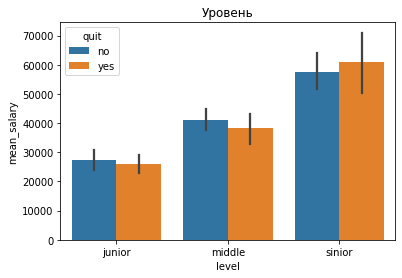

In [93]:
sns.barplot(interesting_data, 
            x='level',
            y='mean_salary',
            hue='quit')
plt.title('Уровень')
;

Сотрудники уровня sinior уходят с большей зарплатой, но выводы делать рано

''

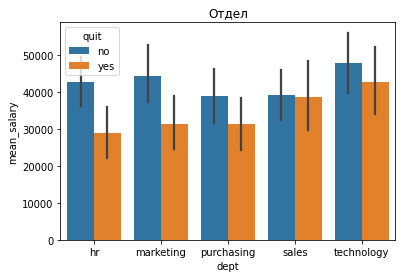

In [94]:
sns.barplot(interesting_data, 
            x='dept',
            y='mean_salary',
            hue='quit')
plt.title('Отдел')
;

Видна большая разница по зарплатам уволившихся сотрудников по отделам

''

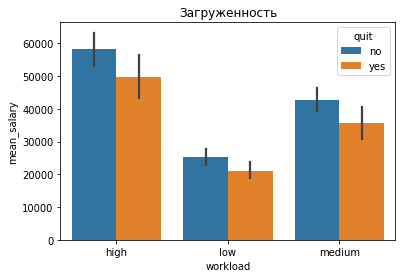

In [95]:
sns.barplot(interesting_data, 
            x='workload',
            y='mean_salary',
            hue='quit')
plt.title('Загруженность')
;

При равной загруженности уходят сотрудники с более низкими зарплатами

##### Промежуточный вывод

1) В отделах продаж и разработки самый высокий уровень зарплат у уволившихся работников;<br>
2) С большей зарплаты в большинстве своем уходят сеньоры, видимо из отделов продаж и разработки;<br>
3) По всем остальным пунктам уходят сотрудники с зарплаты ниже средней по аналогичным критериям

##### Сравнение внутри групп по признакам

Функция для визуализации сравнения признаков

P.S. цветовая палитра выбрана из-за особенностей отображения используемого монитора

In [96]:
def visual_count(column_check, name_first, name_second):
    check_data = interesting_data
    count_all = check_data['count'].sum()
    check_data = check_data[['quit', column_check, 'count']].groupby(by=['quit', column_check]).sum()
    check_data['percent_in_all'] = round(check_data['count'] / count_all * 100, 1)
    check_data = check_data.reset_index(drop=False)
    
    check_data_percent_in = check_data[[column_check, 'count']].groupby(by=column_check).sum().reset_index(drop=False)
    print([column_check, 'count'])
    check_data_percent_in.columns=[column_check, 'count_in_category']
    
    check_data = check_data.merge(check_data_percent_in, on=column_check, how='left')
    check_data['percent_in_category'] = round(check_data['count'] / check_data['count_in_category'] * 100, 1)
    
    plt.figure(figsize=(12, 3))
    
    plt.subplot(1, 2, 1)
    ax = sns.barplot(
            check_data, 
            x='quit',
            y='percent_in_all',
            hue=column_check,
            palette="flare")
    for i in ax.containers:
        ax.bar_label(i,)
    plt.title(name_first)
        
    plt.subplot(1, 2, 2)
    ax = sns.barplot(
            check_data, 
            x=column_check,
            y='percent_in_category',
            hue='quit',
            palette="flare")
    for i in ax.containers:
        ax.bar_label(i,)
    plt.title(name_second)

['level', 'count']


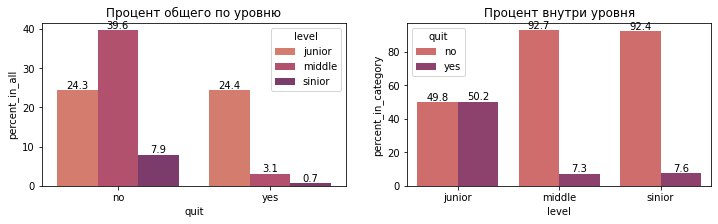

In [97]:
visual_count('level', 'Процент общего по уровню', 'Процент внутри уровня')

1) Больше всего уходят junior, предположительно для быстрого повышения в другой компании или несоответствия ожиданиям;<br>
2) Остается половина сотрудников junior;<br>
3) Остальные распределены одинаково

['dept', 'count']


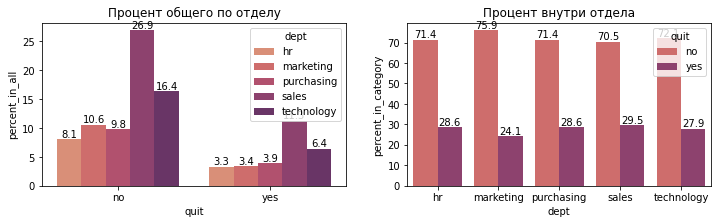

In [98]:
visual_count('dept', 'Процент общего по отделу', 'Процент внутри отдела')

1) По количеству больше всего уходят из продаж, на втором месте технологии;<br>
2) Внутри групп соотношение близко относительно друг друга, но в маркетинге уходяят меньше всего

['workload', 'count']


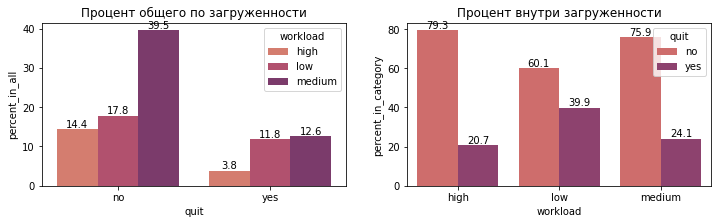

In [99]:
visual_count('workload', 'Процент общего по загруженности', 'Процент внутри загруженности')

1) Больше всего уходят сотрудники с низкой и средней загруженностью;<br>
2) По второму графику выделяется низкая загруженность, таких сотрудников уходит больше всего

['last_year_promo', 'count']


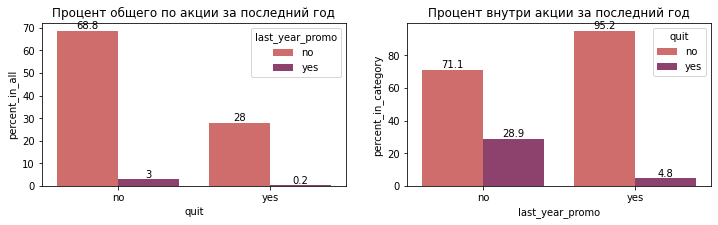

In [100]:
visual_count('last_year_promo', 'Процент общего по акции за последний год', 'Процент внутри акции за последний год')

По всей видимости акции компании привлекают сотрудников

['last_year_violations', 'count']


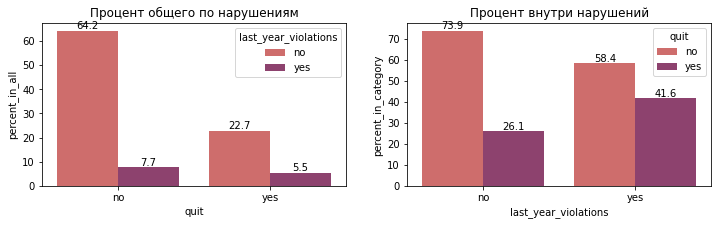

In [101]:
visual_count('last_year_violations', 'Процент общего по нарушениям', 'Процент внутри нарушений')

Хотя общий процент ушедших с нарушениями и без малоразличим, внутри группы с нарушениями процент уволившихся больше

##### Промежуточный вывод

Чаще увольняются сотрудники:<br>
1) Уровня junior;<br>
2) Без акций от компании;<br>
3) Те, кто чаще нарушают;<br>

#### Анализ оценки удовлетворенности сотрудника

Соединим предсказанные значения с датафреймом для дальнейшей работы

In [102]:
df_test_second

,id,quit,quit_bool,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,999029,yes,1,technology,junior,medium,1,no,no,3,31200
1,372846,no,0,sales,middle,medium,10,no,yes,2,32400
2,726767,no,0,marketing,middle,low,7,no,no,4,20400
3,490105,no,0,purchasing,middle,low,7,no,no,4,19200
4,416898,yes,1,purchasing,junior,low,1,no,no,4,12000
...,...,...,...,...,...,...,...,...,...,...,...
1995,836109,yes,1,sales,junior,high,1,no,no,3,33600
1996,180999,yes,1,purchasing,junior,low,2,no,no,4,12000
1997,746018,no,0,hr,middle,medium,2,no,no,4,46800
1998,247658,no,0,sales,middle,medium,1,no,no,5,38400


In [103]:
full_test_df = y_for_future.merge(df_test_second,
                                  on='id',
                                  how='left')

In [104]:
full_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      2000 non-null   int64  
 1   job_satisfaction_rate   2000 non-null   float64
 2   pred_satisfaction_rate  2000 non-null   float64
 3   quit                    2000 non-null   object 
 4   quit_bool               2000 non-null   int64  
 5   dept                    1997 non-null   object 
 6   level                   1999 non-null   object 
 7   workload                1999 non-null   object 
 8   employment_years        2000 non-null   int64  
 9   last_year_promo         2000 non-null   object 
 10  last_year_violations    2000 non-null   object 
 11  supervisor_evaluation   2000 non-null   int64  
 12  salary                  2000 non-null   int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 218.8+ KB


''

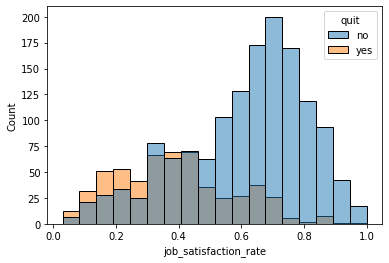

In [105]:
sns.histplot(
    data=full_test_df,
    x='job_satisfaction_rate',
    hue='quit')
;

По графику видно два распределения удовлетворенности работника по статусу работы

#### Вывод

- Обработка датафремов:<br>
1) Найдены пробелы (' ') в выборках и замены на проупски;<br>
2) Распределения похожи на нормальные, но целевой признак имеет 2 вершины;<br>
3) Отдел и наличие акций за последний год имеют самую низкую корреляцию с другими признаками

- Составление портрета уволившегося сотрудника<br>
1) В отделах продаж и разработки самый высокий уровень зарплат у уволившихся работников;<br>
2) С большей зарплаты в большинстве своем уходят сеньоры, видимо из отделов продаж и разработки;<br>
3) По всем остальным пунктам уходят сотрудники с зарплаты ниже средней по аналогичным критериям

- Чаще увольняются сотрудники:<br>
1) Уровня junior;<br>
2) Без акций от компании;<br>
3) Те, кто чаще нарушают;<br>

- Выделено два наиболее выделяющихся портрета:<br>
1) Сеньор из отдела продаж или технологий, возможно с низкой загруженностью и нарушениями;<br>
2) Junior с низкой зарплатой и нагруженностью, возможно с нарушениями и без акций (вероятно который находится на испытательном сроке)

Добавлен новый признак из предыдущего задания

### Добавление нового входного признака

Новый признак добавлен на предыдущем шаге

### Подготовка данных

#### Подготовка переменных и констант

Константы для моделей

In [106]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [107]:
drop_tables = ['id', 'quit']

In [108]:
df_train = full_test_df.drop(columns=drop_tables, axis=0)
df_train.head()

,job_satisfaction_rate,pred_satisfaction_rate,quit_bool,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,0.80,0.880000,0,hr,junior,low,2,no,no,4,19200
1,0.84,0.852000,0,marketing,junior,low,4,no,no,4,16800
2,0.79,0.806000,0,purchasing,middle,high,5,no,no,4,55200
3,0.75,0.813333,0,sales,middle,medium,5,no,no,4,43200
4,0.69,0.693333,0,sales,middle,high,6,no,no,4,48000


Выделим целевой признак и уберем его из переменных с использумыми столбцами. В нашем случае числовыми.

In [109]:
target_column_second = 'quit_bool'

In [110]:
str_col = df_train.select_dtypes(include=[np.object]).columns
str_col

/tmp/ipykernel_308/3551200509.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  str_col = df_train.select_dtypes(include=[np.object]).columns


Index(['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations'], dtype='object')

Выделим названия столбцов для кодировщиков и числовые

In [111]:
ohe_columns_second = ['last_year_promo', 'last_year_violations']
ord_columns_second = ['dept', 'level', 'workload']

In [112]:
num_columns_second = df_train.select_dtypes(include='number').columns
num_columns_second

Index(['job_satisfaction_rate', 'pred_satisfaction_rate', 'quit_bool',
       'employment_years', 'supervisor_evaluation', 'salary'],
      dtype='object')

In [113]:
num_columns_second = [x for x in num_columns_second if x != target_column_second]
num_columns_second

['job_satisfaction_rate',
 'pred_satisfaction_rate',
 'employment_years',
 'supervisor_evaluation',
 'salary']

Разобьем выборку на тестовую и тренировочную

In [114]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    df_train.drop(target_column_second, axis=1),
    df_train[target_column_second],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_train[target_column_second])

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

#### Пайпланы для предобработки

Добавление пайплайнов предобработки датасетов

In [115]:
display(f"ohe_columns: {ohe_columns_second}")
display(f"ord_columns: {ord_columns_second}")

"ohe_columns: ['last_year_promo', 'last_year_violations']"

"ord_columns: ['dept', 'level', 'workload']"

In [116]:
ohe_pipe_second = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(
                                missing_values=np.nan,
                                strategy='most_frequent'
                           )),
     ('ohe', OneHotEncoder(
                 drop='first',
                 handle_unknown='ignore',
                 sparse_output=False))
    ]
    )

In [117]:
ord_pipe_second = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(
                                      missing_values=np.nan,
                                      strategy='most_frequent'
                                  )),
     ('ord', OrdinalEncoder(
                 categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high']
                 ], 
                 handle_unknown='use_encoded_value',
                 unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan,
                                               strategy='most_frequent'))
    ]
)

In [118]:
data_preprocessor_second = ColumnTransformer(
    [('ohe', ohe_pipe_second, ohe_columns),
     ('ord', ord_pipe_second, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

### Обучение моделей

#### Пайплайн для моделей обучения

Добавление пайплайна для моделирования

In [119]:
pipe_final_second = Pipeline([
    ('preprocessor', data_preprocessor_second),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [120]:
param_grid_second = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(10, 25),
        'models__max_features': range(10, 100),
        'models__min_samples_split': range(2, 50),
        'models__min_samples_leaf': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели SVC()
    {
        'models': [SVC(
            probability= True,
            kernel='poly',
            random_state=RANDOM_STATE
        )],
        'models__degree': range(1, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

#### Поиск лучшей модели

In [121]:
randomized_search_second = RandomizedSearchCV(
    pipe_final_second, 
    param_grid_second, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
randomized_search_second.fit(X_train_s, y_train_s)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pip...
                                        {'models': [SVC(kernel='poly',
                                                        probability=True,
                                                        random_state=42)],
                                         'models__degree': range(1, 6),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   scoring='roc_auc')

In [122]:
best_logistic = randomized_search_second.best_estimator_

In [123]:
print('Лучшая модель и её параметры:\n\n', best_logistic)
print('Метрика лучшей модели на тренировочной выборке:', randomized_search_second.best_score_)
# y_test_pred = randomized_search.predict(X_test_use)
y_test_pred = best_logistic.predict_proba(X_test_s)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(np.array(y_test_s), y_test_pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [124]:
result = pd.DataFrame(randomized_search_second.cv_results_)
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')) 

,rank_test_score,param_models,mean_test_score,params
4,1,DecisionTreeClassifier(random_state=42),0.932078,"{'preprocessor__num': 'passthrough', 'models__..."
1,2,DecisionTreeClassifier(random_state=42),0.930904,"{'preprocessor__num': MinMaxScaler(), 'models_..."
7,3,DecisionTreeClassifier(random_state=42),0.930103,"{'preprocessor__num': StandardScaler(), 'model..."
9,4,DecisionTreeClassifier(random_state=42),0.929972,"{'preprocessor__num': MinMaxScaler(), 'models_..."
6,5,DecisionTreeClassifier(random_state=42),0.928975,"{'preprocessor__num': StandardScaler(), 'model..."
2,6,DecisionTreeClassifier(random_state=42),0.927761,"{'preprocessor__num': StandardScaler(), 'model..."
0,7,DecisionTreeClassifier(random_state=42),0.926677,"{'preprocessor__num': MinMaxScaler(), 'models_..."
5,8,DecisionTreeClassifier(random_state=42),0.925807,"{'preprocessor__num': 'passthrough', 'models__..."
3,9,DecisionTreeClassifier(random_state=42),0.924794,"{'preprocessor__num': StandardScaler(), 'model..."
8,9,DecisionTreeClassifier(random_state=42),0.924794,"{'preprocessor__num': StandardScaler(), 'model..."


Лучшей моделью оказалась решающее дерево:
1) ROC-AUC:<br>
тренировочная выборка: 0.93;<br>
тестовая выборка: 0.942.<br>
1) Параметры:<br>
max_depth=19;<br>
max_features=18;<br>
min_samples_leaf=3;<br>
min_samples_split=34

Визуализация дерева решений. Выведем первые 2 уровня для просмотра наиболее значимых переменных

In [125]:
pipe_final_second.named_steps['preprocessor'].fit_transform(X_train_s)
;

''

In [126]:
features_names_X_s = list(pipe_final_second.named_steps['preprocessor'].get_feature_names_out())
features_names_X_s = [[x[5:], features_names_X_s.index(x) + 1] for x in features_names_X_s]
features_names_X_s

[['dept_marketing', 1],
 ['dept_purchasing', 2],
 ['dept_sales', 3],
 ['dept_technology', 4],
 ['last_year_promo_yes', 5],
 ['last_year_violations_yes', 6],
 ['level', 7],
 ['workload', 8],
 ['employment_years', 9],
 ['supervisor_evaluation', 10],
 ['salary', 11],
 ['nder__job_satisfaction_rate', 12],
 ['nder__pred_satisfaction_rate', 13]]

Text(0.5, 0.875, 'x[6] <= 0.5\ngini = 0.405\nsamples = 1500\nvalue = [1077.0, 423.0]')

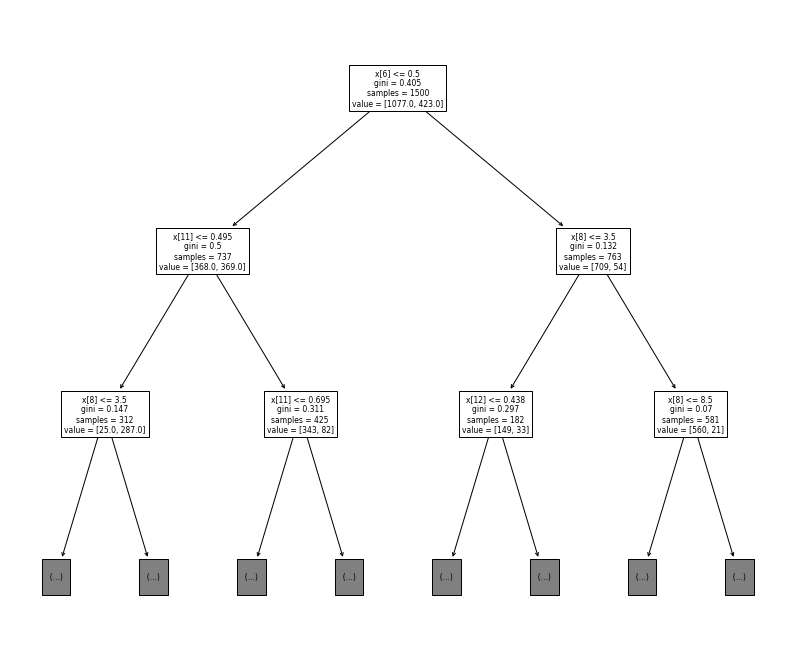

In [127]:
plt.figure(figsize=(14, 12))

plot_tree(best_logistic.named_steps['models'],
          max_depth=2)[0]

По данному дереву в приоритете стоит присутствие нарушений. Следом идут зарплата и нагруженнось

### Вывод

По всей видимости решающее дерево является лучшей моделью, поскольку нам необходимо получить нелинейную зависимость. При этом для метода ближайших соседей могут быть наблюдения, которые находятся слишком близко, чтобы разделить их. А полиномимальная зависимость не учитывает некоторых особенностей данных.

## Общий вывод

### Описание задачи

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли.<br>
Общая задача была разделена на 2:<br>
1) Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.<br>
2) Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

### Этапы работы

#### Подготовительная часть

Были использованы библиотеки:<br>
sklearn, phik, pandas, numpy, seaborn, matplotlib

#### Задача 1

1,2) Данные были загружены и проверены на соответствие;<br>
3) В исследовательском анализе данных были проверены значения данных и заменены некорректные значения;<br>
4) Подготовлены пайплайны для предобработки данных с OneHotEncoder и OrdinalEncoder;<br>
5) С помощью пайплайна была получена лучшая модель из 2 использованных (Решающее дерево и Линейная регрессия). Выбрана лучшая с помощью метрики SMAPE - дерево;<br>
6) Подведены выводы к задаче 1;<br>

#### Задача 2

1,2) Данные были загружены и проверены на соответствие;<br>
3) В исследовательском анализе данных были проверены значения данных и заменены некорректные значения. Также были описанны два наиболее вероятных портрета потенциально увольняющихся сотрудников<br>
5) Подготовлены пайплайны для предобработки данных с OneHotEncoder и OrdinalEncoder;<br>
6) С помощью пайплайна была получена лучшая модель из 4 использованных (SVC, LinearRegression, DecisionTreeClassifier, KNeighborsClassifier). Выбрана лучшая с помощью метрики ROC-AUC - дерево;<br>
7) Подведены выводы к задаче 2;<br>

### Вывод

Наблюдения:<br>
1) В отделах продаж и разработки самый высокий уровень зарплат у уволившихся работников;<br>
2) С большей зарплаты в большинстве своем уходят сеньоры, видимо из отделов продаж и разработки;<br>
3) По всем остальным пунктам уходят сотрудники с зарплаты ниже средней по аналогичным критериям<br>
<br>
Чаще увольняются сотрудники:<br>
1) Уровня junior;<br>
2) Без акций от компании;<br>
3) Те, кто чаще нарушают;<br>
<br>
Выделено два наиболее выделяющихся портрета:<br>
1) Сеньор из отдела продаж или технологий, возможно с низкой загруженностью и нарушениями;<br>
2) Junior с низкой зарплатой и нагруженностью, возможно с нарушениями и без акций (вероятно который находится на испытательном сроке)

Предложения:<br>
1) Чаще проверять заинтересованность Сеньоров в работе (возможно проводя тимбилдинг);<br>
2) Пересмотреть распределение задач и задать новый вектор развития, т.к. учитывая графики нагруженности можно сделать вывод, что человеческие ресурсы распределены неполностью;<br>
3) Пересмотреть акции для работников и учесть их пожелания. Возможно сделать ограниченный выбор из определенного списка акций взамен тех, что имеются;<br>
4) Более детально работать с причиной нарушений для их минимизации и улучшения взаимовыгодных отношений с работником;<br>
5) Нагружать джуниоров больше и привлекать к работе интенсивнее. Рассмотреть вараинт стажировки поочередно в разных смежных отделах;<br>
6) Пересмотреть политику образования зарплат